Functions

In [21]:
def visualize_meshgrid(x, y, target_func, title=None):
    X = np.array(np.meshgrid(x, y))
    Z = target_func(X)
    plt.pcolormesh(x,y,Z, cmap="inferno")
    plt.colorbar()
    if title:
        plt.title(title)
    plt.show()


def generate_sample(n, n_dims, lower, upper, target_func, noise_scale=0, random_state=42):
    """
    Generates data sample.
    """
    rs = np.random.RandomState(random_state)
    X = rs.rand(n_dims,n)
    for i in range(n_dims):
        X[i] = X[i]*(upper[i]-lower[i]) + lower[i]
    y = target_func(X)
    y += rs.normal(0, noise_scale, size=y.shape)
    
    return (X,y)

Generate data sample

In [22]:
import numpy as np

target_func = lambda X: (20 + X**2 - 10 * np.cos(2*np.pi*X)).sum(axis=0)

n_dims = 2
lower_bound = -2.5, -1.5
upper_bound = +1.5, +2.5

In [23]:
X_train, y_train = generate_sample(70, n_dims, lower_bound, upper_bound, target_func)

In [24]:
X_test, y_test = generate_sample(1000, n_dims, lower_bound, upper_bound, target_func, random_state=111)

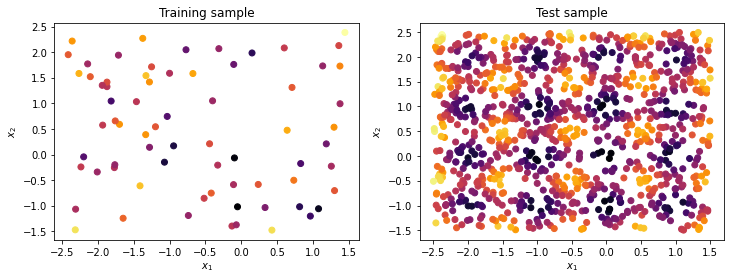

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(X_train[0], X_train[1], c=y_train, cmap="inferno")
plt.title("Training sample")
plt.ylabel("$x_2$")
plt.xlabel("$x_1$")
plt.subplot(122)
plt.scatter(X_test[0], X_test[1], c=y_test, cmap="inferno")
plt.title("Test sample")
plt.ylabel("$x_2$")
plt.xlabel("$x_1$")
plt.show()

Train Default Gaussian Process Model

In [26]:
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.optimize import differential_evolution
from sklearn.gaussian_process.kernels import RBF
gpr = GaussianProcessRegressor(optimizer=differential_evolution, kernel=RBF())
gpr.fit(X_train.T, y_train)
y_pred = gpr.predict(X_train.T)

TypeError: differential_evolution() got multiple values for argument 'bounds'

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
print(f'''Training Errors:
          Log Marginal Likelihood: {gpr.log_marginal_likelihood_value_}
          Mean Squared Error: {mean_squared_error(y_train, y_pred)}
          R2 Score: {r2_score(y_train, y_pred)}
''')

AttributeError: 'GaussianProcessRegressor' object has no attribute 'log_marginal_likelihood_value_'

In [ ]:
y_pred_test = gpr.predict(X_test.T)
print(f'''Test Errors:
          Log Marginal Likelihood: {gpr.log_marginal_likelihood_value_}
          Mean Squared Error: {mean_squared_error(y_test, y_pred_test)}
          R2 Score: {r2_score(y_test, y_pred_test)}
''')

AttributeError: 'GaussianProcessRegressor' object has no attribute 'alpha_'

In [ ]:
gpr.kernel_.theta

array([0.])

In [ ]:
m = np.arange(-2.5,1.5,0.01)
p = np.arange(-1.5,2.5,0.01)
X = np.array(np.meshgrid(m, p))
Y = np.zeros((400,400))
for i in range(len(X.T)):
    Y[i] = gpr.predict(X.T[i])

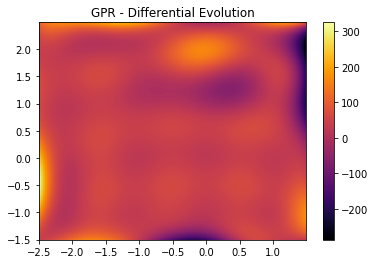

In [ ]:
plt.pcolormesh(np.array(np.meshgrid(m, p))[0], np.array(np.meshgrid(m, p))[1], Y, cmap="inferno")
plt.colorbar()
plt.title("GPR - Differential Evolution")
plt.show()

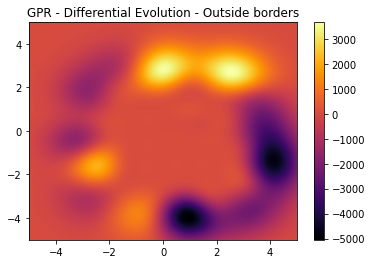

In [ ]:
m = np.arange(-5,5,0.01)
p = np.arange(-5,5,0.01)
X_ = np.array(np.meshgrid(m, p))
Y = np.zeros((len(m),len(p)))
for i in range(len(X_.T)):
    Y[i] = gpr.predict(X_.T[i])

plt.pcolormesh(np.array(np.meshgrid(m, p))[0], np.array(np.meshgrid(m, p))[1], Y, cmap="inferno")
plt.colorbar()
plt.title("GPR - Differential Evolution - Outside borders")
plt.show()

In [ ]:
gpr.kernel_.theta

array([], dtype=float64)

Groundtruth

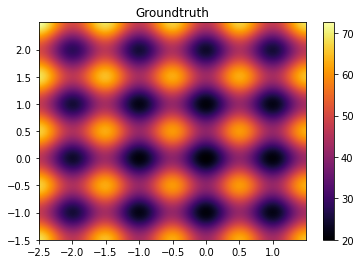

In [ ]:
m = np.arange(-2.5,1.5,0.001)
p = np.arange(-1.5,2.5,0.001)
visualize_meshgrid(m, p, target_func, title='Groundtruth')

In [ ]:
from pyswarm import pso
from pyswarms.single import GlobalBestPSO

options = {"c1": 0.5, "c2": 0.3, "w": 0.9, "k": 2, "p": 2}

bounds = ([-10,-10], [10,10])
opt_ps = GlobalBestPSO(
    n_particles=100, dimensions=2, options=options, bounds=bounds
)

gpr = GaussianProcessRegressor(optimizer=opt_ps.optimize, kernel=RBF())
gpr.fit(X_train.T, y_train)
y_pred = gpr.predict(X_train.T)
print(f'''Training Errors:
          Log Marginal Likelihood: {gpr.log_marginal_likelihood_value_}
          Mean Squared Error: {mean_squared_error(y_train, y_pred)}
          R2 Score: {r2_score(y_train, y_pred)}
''')

2022-07-21 18:16:14,266 - pyswarms.single.global_best - INFO - Optimize for [0.] iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 2, 'p': 2}


TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
import random

likelihood = None

def _rs_optimize(function, dimensions, lower_boundary,
                     upper_boundary, max_iter, maximize=False):
    """https://medium.com/analytics-vidhya/how-does-random-search-algorithm-work-python-implementation-b69e779656d6 (23.07.2022)"""
    best_solution = np.array([float()] * dimensions)

    for i in range(dimensions):
        best_solution[i] = random.uniform(lower_boundary[i],
                                               upper_boundary[i])

    for _ in range(max_iter):

        solution1 = function(best_solution)

        new_solution = [lower_boundary[d] + random.random()
                              *(upper_boundary[d]-
                                    lower_boundary[d]) 
                                       for d in range(dimensions)]

        if np.greater_equal(new_solution,
               lower_boundary).all() and np.less_equal(new_solution
                         ,upper_boundary).all():
            solution2 = function(new_solution)
        elif maximize:
            solution2 = -100000.0
        else:
            solution2 = 100000.0

        if solution2 > solution1 and maximize:
            best_solution = new_solution
        elif solution2 < solution1 and not maximize:
            best_solution = new_solution

    best_fitness = function(best_solution)
    print(function)
    global likelihood 
    likelihood = function

    return best_solution, best_fitness

def rs_optimize(obj_func, initial_theta, bounds, dims=2):
    lower_bound = list(bounds[:,0])*dims
    print(lower_bound)
    upper_bound = list(bounds[:,1])*dims
    print(upper_bound)
    max_iter=1000

    return _rs_optimize(obj_func, dims, lower_bound, upper_bound, max_iter)



In [ ]:
gpr = GaussianProcessRegressor(optimizer=rs_optimize, kernel=RBF())
gpr.fit(X_train.T, y_train)
y_pred = gpr.predict(X_train.T)

[-11.512925464970229, -11.512925464970229]
[11.512925464970229, 11.512925464970229]


ValueError: theta has not the correct number of entries. Should be 1; given are 2

In [ ]:
x = np.arange(-50,100,0.05)
l = [likelihood([e])[0] for e in x]
l_ = [likelihood([e])[1][0] for e in x]

plt.subplot(2,1,1)
plt.plot(x, l, color="b")
plt.subplot(2,1,2)
plt.plot(x, l_, color="red")

TypeError: 'NoneType' object is not callable